In [1]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from ptrail.features.semantic_features import SemanticFeatures

pdf = pd.read_csv('./starkey_new.csv')
starkey = PTRAILDataFrame(data_set=pdf,
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')
print(starkey)


------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


In [2]:
%%time

# generate Kinematic stats.
stats = Statistics.generate_kinematic_stats(dataframe=starkey,
                                            target_col_name='Species')

CPU times: user 36.7 s, sys: 1.26 s, total: 37.9 s
Wall time: 40.1 s


In [3]:
# Pivot the stats df and get it ready for the ML task.
pivoted_stats = Statistics.pivot_stats_df(dataframe=stats,
                                          target_col_name='Species')
pivoted_stats

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,Species
traj_id,,,,,,,,,,,,,,,,,,,,,
910313E37,30.022359,66.956787,149.611989,300.726867,632.269559,0.000000,6034.207873,268.728974,398.901980,1121.185006,...,-0.063322,-0.026677,5.306679e-08,0.025072,0.065316,-6.036678,2.449554,-0.001945,0.154034,1
890424E08,42.384642,84.780370,177.223376,379.614004,759.311144,0.000000,6043.490157,323.956468,446.249248,674.170024,...,-0.064023,-0.023545,0.000000e+00,0.022320,0.063820,-11.536372,2.494857,-0.006703,0.241358,1
921228E06,42.390114,90.066813,200.849995,429.158672,890.194719,0.000000,4623.347553,377.677630,517.650637,807.693739,...,-0.058033,-0.020736,-9.056581e-07,0.020104,0.056057,-56.020652,4.466711,-0.016681,1.008263,1
930304E16,42.384012,67.090258,153.068542,341.254645,690.640774,0.000000,5864.020183,291.351804,396.220730,1156.455188,...,-0.068092,-0.026542,2.094546e-07,0.027375,0.066328,-7.865121,30.406105,0.001768,0.600187,1
940110D01,30.022192,66.956668,149.612107,284.710015,510.276991,0.000000,1975.611748,221.420080,235.093739,492.522877,...,-0.041207,-0.018263,0.000000e+00,0.018564,0.042032,-5.547235,200.192244,0.073830,3.677063,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSUX92071,42.384783,98.213522,275.921086,509.415791,1734.539050,0.000000,4968.850596,552.252200,797.302786,2019.896767,...,-0.013195,-0.006290,-1.456657e-04,0.006863,0.019363,-0.180602,0.032870,-0.001012,0.022347,2
OSUX92008,60.044073,113.846901,323.971240,582.606358,1036.441333,0.000000,3252.044721,469.226709,565.038959,2330.556507,...,-0.033016,-0.006065,4.739615e-05,0.008182,0.023711,-0.119311,0.119162,-0.001884,0.033022,2
OSUX91121,66.956676,138.476526,334.746006,596.234364,1365.947767,42.390056,5886.617958,652.055638,1119.869470,2660.409775,...,-0.010799,-0.003606,1.840711e-04,0.006951,0.023679,-0.018316,0.027926,0.001982,0.011728,2


In [4]:
# Pre-selecting features

from sklearn.feature_selection import mutual_info_classif
from operator import itemgetter

# Convert the dataframe and its answer value to numpy.
X = pivoted_stats.drop(columns='Species').to_numpy()
Y = pivoted_stats['Species'].to_numpy()
mutual_info = mutual_info_classif(X,Y)
feat_list = []
for column, minfo in zip(pivoted_stats.columns, mutual_info):
  feat_list.append([column, round(minfo, 2)])

sorted_flist = sorted(feat_list, key=itemgetter(1), reverse=True)
for i in sorted_flist:
  print(f'Attribute: {i[0]}, score: {round(i[1], 2)}')
# select elements greater than .20
final_list = [i for i in sorted_flist if i[1] >= .3]
# print(final_list)
selected_cols = [i[0] for i in sorted_flist]
# print(selected_cols)

Attribute: 25%_Speed, score: 0.54
Attribute: 75%_Speed, score: 0.5
Attribute: 50%_Speed, score: 0.47
Attribute: 90%_Speed, score: 0.44
Attribute: 10%_Speed, score: 0.43
Attribute: max_Distance_from_start, score: 0.36
Attribute: std_Distance_from_start, score: 0.33
Attribute: 90%_Distance_from_start, score: 0.32
Attribute: 90%_Acceleration, score: 0.28
Attribute: 75%_Distance_from_start, score: 0.27
Attribute: mean_Distance_from_start, score: 0.27
Attribute: 10%_Acceleration, score: 0.25
Attribute: max_Distance, score: 0.24
Attribute: 75%_Acceleration, score: 0.22
Attribute: 10%_Jerk, score: 0.22
Attribute: 90%_Jerk, score: 0.22
Attribute: std_Distance, score: 0.21
Attribute: 75%_Jerk, score: 0.21
Attribute: 90%_Distance, score: 0.2
Attribute: 50%_Distance_from_start, score: 0.2
Attribute: 50%_Bearing, score: 0.2
Attribute: mean_Distance, score: 0.19
Attribute: 25%_Acceleration, score: 0.18
Attribute: 25%_Distance, score: 0.17
Attribute: mean_Speed, score: 0.15
Attribute: 90%_Bearing, s

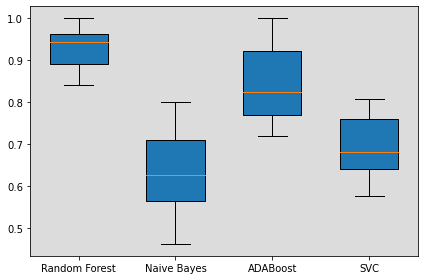

In [5]:
# 1. Classification PipeLine.

from sklearn.model_selection import cross_val_score
# Visualization tools.
import matplotlib.pyplot as plt
import seaborn as sns

# Models.
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Metric calculation.
# from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold



# Declare all the models that we are going to train.
names = ["Random Forest", "Naive Bayes", "ADABoost", "SVC"]
models = [RandomForestClassifier(), GaussianNB(),
          AdaBoostClassifier(), SVC()]

# Convert the dataframe and its answer value to numpy.
X = pivoted_stats.drop(columns='Species').to_numpy()
Y = pivoted_stats['Species'].to_numpy()

# # Separate out 30% of the data for the final testing.
# train_vals, final_test, \
# train_ans, final_test_ans = train_test_split(X, Y, test_size=0.3)


ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
# For each model defined above, predict the species for
# our animals.
for i, name, model in zip(range(0, 4), names, models):
    fit = model.fit(X, Y)
    scores = cross_val_score(model, X, Y,
                             scoring='accuracy', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True, widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
plt.tight_layout()

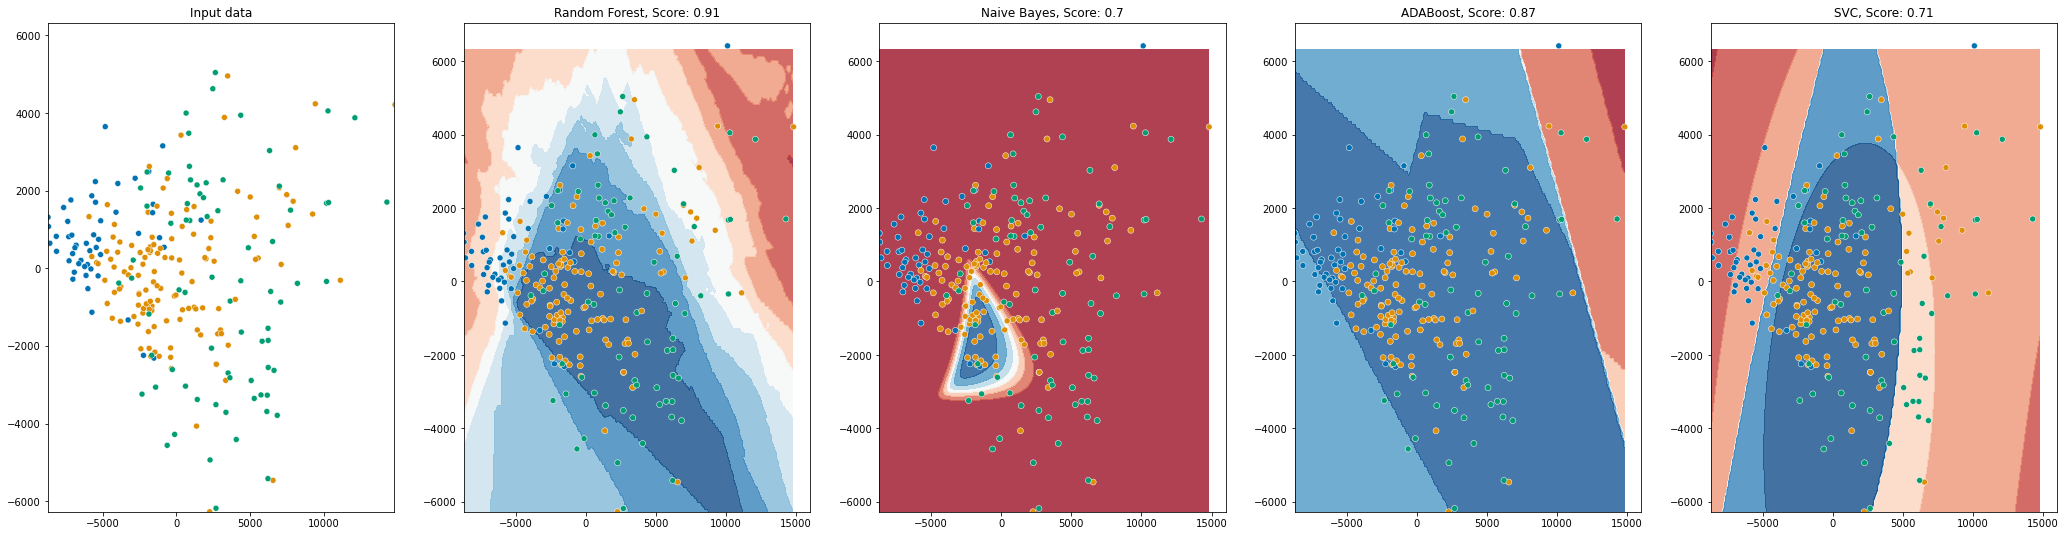

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
from matplotlib.colors import ListedColormap

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,)

# Perform PCA on our df and extract 2 components for visualization purposes.
pca2 = PCA(n_components=2)
transformed2 = pca2.fit_transform(X=X)

# Prepare next figure
fig2, ax2 = plt.subplots(1, 5, figsize=(36, 9))
fig2.set_facecolor('white')
ax2=ax2.flatten()

h = 100
x_min, x_max = transformed2[:, 0].min() - 0.5, transformed2[:, 0].max() + 0.5
y_min, y_max = transformed2[:, 1].min() - 0.5, transformed2[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#00FF00"])

ax2[0].set_title("Input data")
# Plot all points of the dataset.
sns.scatterplot(x=transformed2[:, 0], y=transformed2[:, 1],
                hue=Y, ax=ax2[0], palette='colorblind')
ax2[0].set_xlim(xx.min(), xx.max())
ax2[0].set_ylim(yy.min(), yy.max())
ax2[0].get_legend().remove()

for i, name, model in zip(range(1, len(ax2)), names, models):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)

    # Convert the mesh back to the original values.
    real_X = pca2.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    # print('XX--XX')
    # print(real_X.shape)
    # print(real_X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(model, "decision_function"):
        # print('decision func')
        Z = model.decision_function(real_X)[:, 1]
        vals = model.decision_function(real_X)
    else:
        # print('probability')
        Z = model.predict_proba(real_X)[:, 1]
        vals = model.predict_proba(real_X)

    # Reshape the z values and plot the contour.
    Z = Z.reshape(xx.shape)
    ax2[i].contourf(xx, yy, Z, cmap=cm, alpha=0.8)


    # Now,we plot the points onto the contour and then map their
    # colors according to the regions.
    sns.scatterplot(x=transformed2[:, 0], y=transformed2[:, 1],
                    hue=Y, ax=ax2[i], palette='colorblind')

    ax2[i].set_title(name + f', Score: {round(score, 2)}')
    ax2[i].get_legend().remove()

In [ ]:
    # 2. Clustering Pipeline.
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, Birch, KMeans, AgglomerativeClustering, estimate_bandwidth
from sklearn.metrics import silhouette_score

# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(X, quantile=0.25)

cluster_models = [
    KMeans(n_clusters=3, algorithm='elkan'),
    AgglomerativeClustering(n_clusters=3),
    AgglomerativeClustering(linkage="average", n_clusters=3),
    Birch(n_clusters=3),
    MeanShift(bandwidth=bandwidth, bin_seeding=True),
]

cluster_names = ['KMeans', 'Agglomerative Clustering(Ward)', 'Agglomerative Clustering(Average)', 'Birch', 'MeanShift']

# Perform PCA on our df and extract 2 components for visualization purposes.
pca = PCA(n_components=2)
transformed = pca.fit_transform(X=X)

# Plot true clusters
# sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1],
                    # hue=Y, palette='colorblind')


# Prepare next figure
fig1, ax1 = plt.subplots(2, 3, figsize=(21, 9))
fig1.set_facecolor('white')
ax1=ax1.flatten()

sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=Y, palette='colorblind', ax=ax1[0])
ax1[0].set_title(f'Dataset')
ax1[0].get_legend().remove()
ax1[0].set_facecolor('gainsboro')

# Training the models first and doing their box plots.
for i, name, model in zip(range(0, len(ax1)), cluster_names, cluster_models):
    # Predict the species on the test dataset.
    ans = model.fit_predict(X)
    # calculating silhouete
    score = silhouette_score(X=X, labels=model.labels_)

    # Plot the 2D scatterplot and then set the title of each plot.
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1],
                    hue=ans, palette='colorblind', ax=ax1[i+1])
    ax1[i+1].set_title(f'Model: {name}, Silhouette Score: {round(score, 2)}')
    ax1[i+1].get_legend().remove()
    ax1[i+1].set_facecolor('gainsboro')